In [2]:
!pip install git+https://github.com/feralvam/easse.git

  Cloning https://github.com/feralvam/easse.git to /private/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/pip-req-build-37_m8vdy
  Running command git clone --filter=blob:none --quiet https://github.com/feralvam/easse.git /private/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/pip-req-build-37_m8vdy
  Resolved https://github.com/feralvam/easse.git to commit 6a4352ec299ed03fda8ee45445ca43d9c7673e89
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/text-simplification-evaluation.git (to revision main) to /private/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/pip-install-88eakzl_/tseval_801caaa351734d1f8c2b0e11a18f13c9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/text-simplification-evaluation.git /private/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/pip-install-88eakzl_/tseval_801caaa351734d1f8c2b0e11a18f13c9
  Resolved https://github.com/facebookresearch/text-simplification-evaluation.git to commi

In [4]:
!pip install sacrebleu rouge-score textstat ruts openpyxl

In [6]:
# В начале ноутбука добавьте «заплатку» для pymorphy2/inspect:
import inspect
if not hasattr(inspect, 'getargspec'):
    inspect.getargspec = inspect.getfullargspec

In [8]:
# Автоматическое объединение, оценка и визуализация результатов упрощения

## 1. Импорты и установка зависимостей

import os, glob, re
import pandas as pd
import matplotlib.pyplot as plt

from easse.sari import corpus_sari
import sacrebleu
from rouge_score import rouge_scorer
import textstat
import ruts

In [10]:
files = glob.glob('*.xlsx')
print(files)

['unique_texts_with_mistral.xlsx', 'unique_texts_200_formatted_golden_standard_vikhr_llama.xlsx', 'unique_texts_200_qwen_results_final.xlsx', 'unique_texts_200_formatted_golden_standard_simplified.xlsx']


In [12]:
## 2. Объединяем шесть файлов в один DataFrame

# Путь к папке
PATH = '.'
files = glob.glob(os.path.join(PATH, '*.xlsx'))

# Собираем все таблицы в список
dfs = []
for fp in files:
    df = pd.read_excel(fp)
    # нормализуем имена колонок
    df.columns = df.columns.str.strip()
    dfs.append(df)

# Начинаем с первого DataFrame, оставляя только оригинал и эталон
base = dfs[0][['unique_text', 'golden_standard']].copy()
for df in dfs:
    # находим колонку с выходами модели
    model_cols = [c for c in df.columns if c not in ['unique_text', 'golden_standard']]
    if len(model_cols) != 1:
        raise ValueError(f"В файле {df} неожиданное число колонок моделей: {model_cols}")
    col = model_cols[0]
    base = base.merge(df[['unique_text', col]],
                      on='unique_text', how='left')

# Переименуем для удобства
base = base.rename(columns={
    'unique_text': 'original_text',
    'golden_standard': 'reference'
})

# Порядок столбцов: оригинал → эталон → все модели
model_cols = [c for c in base.columns if c not in ['original_text','reference']]
base = base[['original_text','reference'] + model_cols]

# Сохраним промежуточный CSV
base.to_csv('combined_results.csv', index=False)

In [14]:
## 3. Очистка текстов от пустых строк (нужна для стабильности SARI)

def normalize(text):
    if pd.isna(text): return ''
    lines = [ln.strip() for ln in str(text).splitlines() if ln.strip()]
    return "\n".join(lines)

for col in base.columns:
    base[col] = base[col].apply(normalize)

In [20]:
## 4. Подсчёт метрик вручную

# Подготовка исходных списков
srcs = base['original_text'].tolist()
refs = [ base['reference'].tolist() ]  # один список длины N
hyps = base[m].tolist()
sari = corpus_sari(srcs, hyps, refs)

scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
results = []

for m in model_cols:
    hyps = base[m].tolist()
    # SARI
    sari = corpus_sari(srcs, hyps, refs)
    # BLEU
    bleu = sacrebleu.corpus_bleu(hyps, [base['reference'].tolist()]).score
    # ROUGE
    scores = [scorer.score(r[0], h) for h, r in zip(hyps, refs)]
    rouge1 = sum(s['rouge1'].fmeasure for s in scores)/len(scores)
    rouge2 = sum(s['rouge2'].fmeasure for s in scores)/len(scores)
    rougeL = sum(s['rougeL'].fmeasure for s in scores)/len(scores)
    # Доп. метрика: читаемость Flesch-Reading-Ease
    fre = textstat.flesch_reading_ease(" ".join(hyps))
    results.append({
        'model': m,
        'sari': round(sari,2),
        'bleu': round(bleu,2),
        'rouge1': round(rouge1,2),
        'rouge2': round(rouge2,2),
        'rougeL': round(rougeL,2),
        'flesch_reading': round(fre,2)
    })

metrics_df = pd.DataFrame(results).sort_values('sari', ascending=False)
metrics_df.to_csv('model_metrics.csv', index=False)
metrics_df

,model,sari,bleu,rouge1,rouge2,rougeL,flesch_reading
1,llama_finetuned,47.99,38.17,0.0,0.0,0.0,108.20
0,mistral_instruct,45.86,35.25,0.0,0.0,0.0,106.00
2,qwen_finetuned,40.01,15.57,0.0,0.0,0.0,109.24
3,deepseek-v3,39.64,15.89,0.0,0.0,0.0,111.45


In [24]:
from ruts import BasicStats, DiversityStats, ReadabilityStats

ruts_results = []
for m in model_cols:
    hyps = [h for h in base[m].tolist() if isinstance(h, str) and h.strip()]
    text_all = "\n".join(hyps)

    bs = BasicStats(text_all).get_stats()
    ds = DiversityStats(text_all).get_stats()
    rs = ReadabilityStats(text_all).get_stats()

    # MorphStats может падать — обернём в try/except
    try:
        from ruts import MorphStats
        ms = MorphStats(text_all).get_stats()
    except Exception:
        ms = {}

    entry = {'model': m}
    entry.update(bs); entry.update(ds); entry.update(ms); entry.update(rs)
    ruts_results.append(entry)

ruts_df = pd.DataFrame(ruts_results)

In [26]:
ruts_df.to_csv('ruts_statistics.csv', index=False)
ruts_df

,model,c_letters,c_syllables,n_sents,n_words,n_unique_words,n_long_words,n_complex_words,n_simple_words,n_monosyllable_words,...,mamtld,hdd,simpson_index,hapax_index,flesch_kincaid_grade,flesch_reading_easy,coleman_liau_index,smog_index,automated_readability_index,lix
0,mistral_instruct,"{1: 2987, 2: 1956, 3: 2299, 4: 1778, 5: 2661, ...","{0: 3731, 1: 4175, 2: 6171, 3: 5745, 4: 3938, ...",1952,28084,7547,16403,8262,16091,4175,...,183.596082,0.949126,320.935250,1033.318554,9.529608,31.131929,11.606400,18.239118,11.606400,72.794217
1,llama_finetuned,"{1: 3006, 2: 2459, 3: 2319, 4: 1676, 5: 2601, ...","{0: 4078, 1: 4218, 2: 6160, 3: 5779, 4: 3954, ...",2135,28294,6960,16233,8059,16157,4218,...,133.607189,0.943864,291.023824,992.434102,8.566513,35.958203,10.575825,17.227129,10.575825,70.625047
2,qwen_finetuned,"{1: 2481, 2: 3628, 3: 1999, 4: 1363, 5: 2192, ...","{0: 5035, 1: 3304, 2: 5375, 3: 5236, 4: 3498, ...",2056,25815,6468,14152,6865,13915,3304,...,146.887940,0.906201,121.273983,1046.808105,7.138964,45.806665,8.032386,16.205398,8.032386,67.376774
3,deepseek-v3,"{1: 2245, 2: 2904, 3: 1774, 4: 1272, 5: 1973, ...","{0: 4300, 1: 2865, 2: 4858, 3: 4223, 4: 2511, ...",2076,20590,5320,10422,4344,11946,2865,...,132.657637,0.900809,120.523660,1025.408926,4.308957,61.893669,4.646706,12.839106,4.646706,60.534916


In [28]:
import re

# 1) Функция Флеша–Кинкейда (адаптированная для русского)
def fk_grade(text: str) -> float:
    # Разбиваем на предложения
    sents = [s for s in re.split(r'[.!?]+', text) if s.strip()]
    num_sentences = len(sents) or 1

    # Извлекаем слова
    words = re.findall(r'\w+', text, flags=re.UNICODE)
    num_words = len(words) or 1

    # Считаем слоги как количество гласных
    vowels = set('аеёиоуыэюяАЕЁИОУЫЭЮЯ')
    syllable_count = sum(1 for w in words for ch in w if ch in vowels)

    # Собственно формула
    return 0.5 * (num_words / num_sentences) + 8.4 * (syllable_count / num_words) - 15.59

# 2) Пример интеграции в ваш вычислительный блок
results = []
for m in model_cols:
    hyp_text = " ".join([h for h in base[m].tolist() if h.strip()])
    fk  = fk_grade(hyp_text)

    # остальные ваши метрики: sari, bleu, rouge...
    sari = corpus_sari(srcs, base[m].tolist(), [base['reference'].tolist()])
    bleu = sacrebleu.corpus_bleu(base[m].tolist(), [base['reference'].tolist()]).score

    results.append({
        'model': m,
        'sari': round(sari,2),
        'bleu': round(bleu,2),
        'fk_grade': round(fk,2),
        # ...другие метрики
    })

metrics_df = pd.DataFrame(results).sort_values('sari', ascending=False)
metrics_df


,model,sari,bleu,fk_grade
1,llama_finetuned,47.99,38.17,10.93
0,mistral_instruct,45.86,35.25,11.66
2,qwen_finetuned,40.01,15.57,10.72
3,deepseek-v3,39.64,15.89,7.76


In [32]:
!pip install git+https://github.com/feralvam/easse.git sacrebleu nltk

  Cloning https://github.com/feralvam/easse.git to /private/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/pip-req-build-drxjg14q
  Running command git clone --filter=blob:none --quiet https://github.com/feralvam/easse.git /private/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/pip-req-build-drxjg14q
  Resolved https://github.com/feralvam/easse.git to commit 6a4352ec299ed03fda8ee45445ca43d9c7673e89
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/text-simplification-evaluation.git (to revision main) to /private/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/pip-install-_nkh9qj5/tseval_6b63900385504221b5fcc78de68b9386
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/text-simplification-evaluation.git /private/var/folders/0v/tzcygl612vvdz00kp8wyv3th0000gn/T/pip-install-_nkh9qj5/tseval_6b63900385504221b5fcc78de68b9386
  Resolved https://github.com/facebookresearch/text-simplification-evaluation.git to commi

In [36]:
from nltk.translate.meteor_score import meteor_score

# Подготовка исходных списков
srcs = base['original_text'].tolist()
refs = [ base['reference'].tolist() ]  # один список длины N
hyps = base[m].tolist()
sari = corpus_sari(srcs, hyps, refs)
srcs = base['original_text'].tolist()
refs_single = base['reference'].tolist()

results = []
for m in model_cols:
    hyps = base[m].tolist()
    # SARI
    sari = corpus_sari(srcs, hyps, [refs_single])
    # BLEU
    bleu = sacrebleu.corpus_bleu(hyps, [refs_single]).score

    # METEOR: каждый раз передаём списки слов
    meteor_scores = [
        meteor_score([ref.split()], hyp.split())
        for ref, hyp in zip(refs_single, hyps)
        if hyp.strip()
    ]
    meteor = 100 * sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0

    results.append({
        'model': m,
        'sari': round(sari, 2),
        'bleu': round(bleu, 2),
        'meteor': round(meteor, 2),
    })

metrics_df = pd.DataFrame(results).sort_values('sari', ascending=False)
metrics_df

,model,sari,bleu,meteor
1,llama_finetuned,47.99,38.17,54.98
0,mistral_instruct,45.86,35.25,52.03
2,qwen_finetuned,40.01,15.57,30.33
3,deepseek-v3,39.64,15.89,28.17


In [38]:
import pandas as pd
import inspect
from ruts import BasicStats, DiversityStats, ReadabilityStats, MorphStats
import matplotlib.pyplot as plt

In [40]:
# Патч для pymorphy2/inspect (нужно до первого импорта MorphStats)
if not hasattr(inspect, 'getargspec'):
    full = inspect.getfullargspec
    def getargspec(func):
        spec = full(func)
        return spec.args, spec.varargs, spec.varkw, spec.defaults
    inspect.getargspec = getargspec

# 1. Загрузить объединённый CSV (созданный ранее)
base = pd.read_csv('combined_results.csv')

# 2. Рассчитать ruts-метрики для каждого столбца
ruts_results = []
for col in base.columns:
    texts = [t for t in base[col].astype(str).tolist() if t.strip()]
    text_all = "\n".join(texts)

    bs = BasicStats(text_all).get_stats()
    ds = DiversityStats(text_all).get_stats()
    rs = ReadabilityStats(text_all).get_stats()
    try:
        ms = MorphStats(text_all).get_stats()
    except Exception:
        ms = {}

    stats = {}
    stats.update(bs); stats.update(ds); stats.update(ms); stats.update(rs)
    stats['column'] = col
    ruts_results.append(stats)

ruts_df = pd.DataFrame(ruts_results)

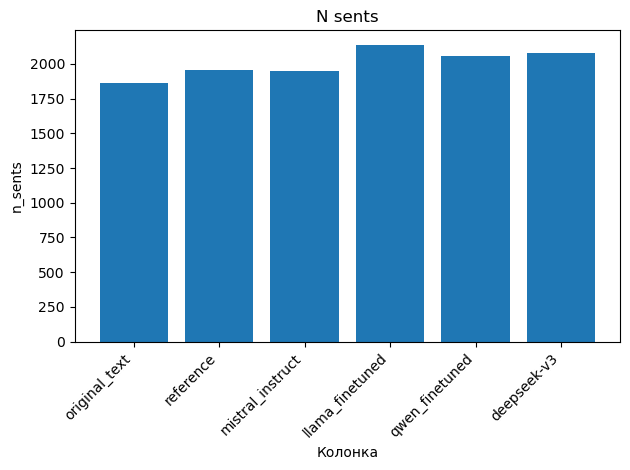

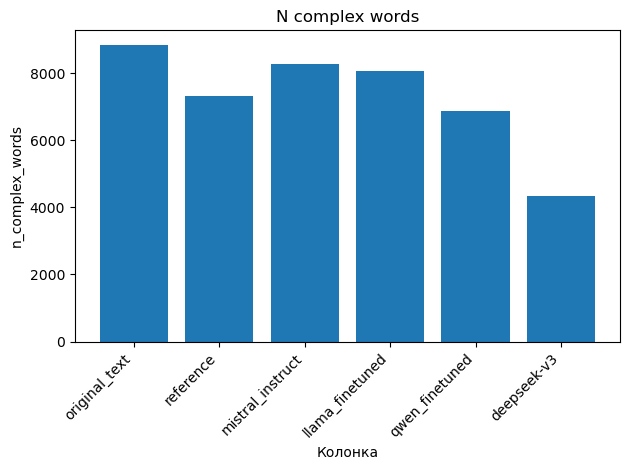

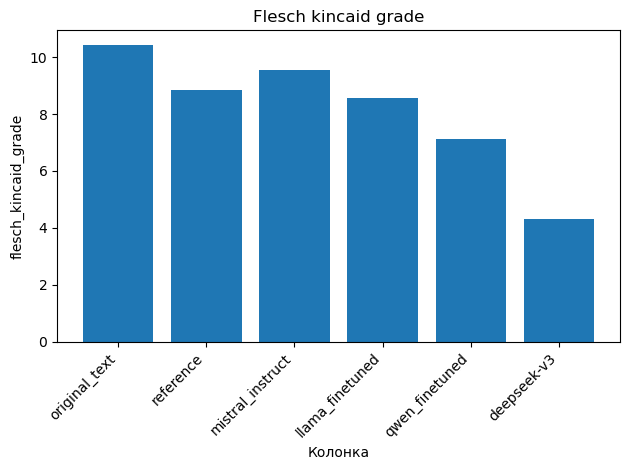

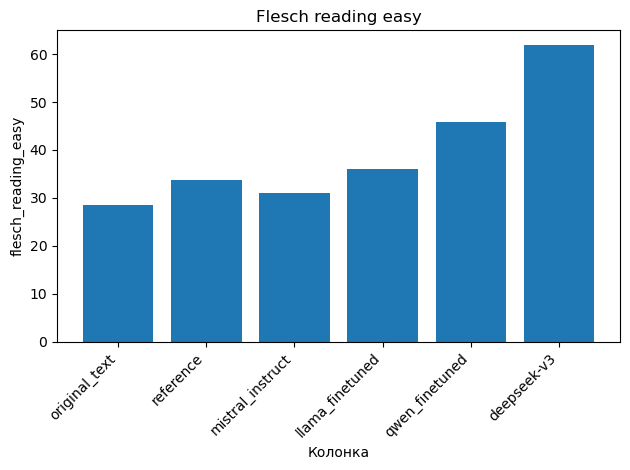

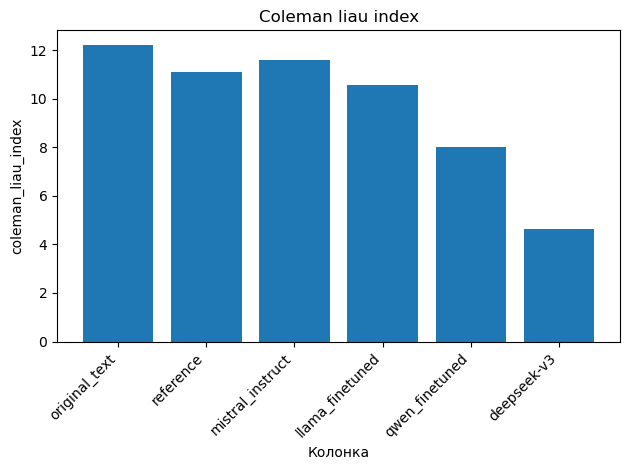

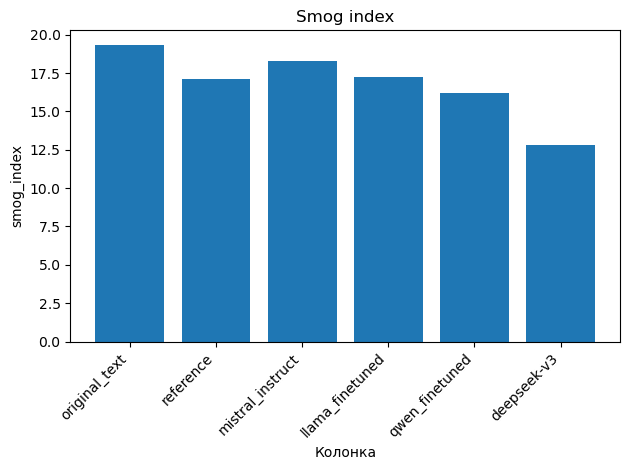

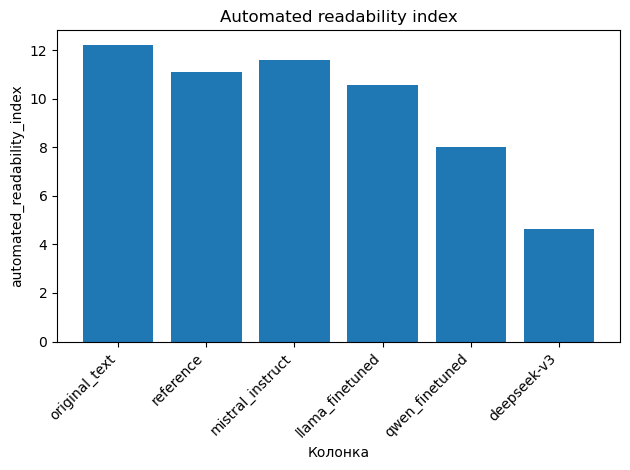

In [42]:
# 3. Сохранить в новый файл
ruts_df.to_csv('combined_ruts_all.csv', index=False)

# 4. Визуализация выбранных показателей
metrics_to_plot = [
    'n_sents', 'n_complex_words', 'flesch_kincaid_grade',
    'flesch_reading_easy', 'coleman_liau_index',
    'smog_index', 'automated_readability_index'
]

for metric in metrics_to_plot:
    plt.figure()
    plt.bar(ruts_df['column'], ruts_df[metric])
    plt.xticks(rotation=45, ha='right')
    plt.title(metric.replace('_', ' ').capitalize())
    plt.xlabel('Колонка')
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

In [44]:
ruts_df

,c_letters,c_syllables,n_sents,n_words,n_unique_words,n_long_words,n_complex_words,n_simple_words,n_monosyllable_words,n_polysyllable_words,...,hdd,simpson_index,hapax_index,flesch_kincaid_grade,flesch_reading_easy,coleman_liau_index,smog_index,automated_readability_index,lix,column
0,"{1: 3462, 2: 2236, 3: 2339, 4: 1790, 5: 2631, ...","{0: 4042, 1: 4655, 2: 6268, 3: 6247, 4: 4055, ...",1859,30044,7797,17586,8832,17170,4655,21347,...,0.946449,296.036940,1016.392349,10.425607,28.605818,12.212171,19.320757,12.212171,74.695527,original_text
1,"{1: 2791, 2: 2069, 3: 1980, 4: 1588, 5: 2421, ...","{0: 3184, 1: 4009, 2: 5827, 3: 5709, 4: 3663, ...",1959,26037,6803,15188,7308,15545,4009,18844,...,0.945686,300.488891,997.650787,8.859340,33.652678,11.094900,17.126191,11.094900,71.623338,reference
2,"{1: 2987, 2: 1956, 3: 2299, 4: 1778, 5: 2661, ...","{0: 3731, 1: 4175, 2: 6171, 3: 5745, 4: 3938, ...",1948,28084,7547,16403,8262,16091,4175,20178,...,0.949126,320.935250,1033.318554,9.544084,31.093524,11.614686,18.257783,11.614686,72.823760,mistral_instruct
3,"{1: 3006, 2: 2459, 3: 2319, 4: 1676, 5: 2601, ...","{0: 4078, 1: 4218, 2: 6160, 3: 5779, 4: 3954, ...",2135,28294,6960,16233,8059,16157,4218,19998,...,0.943864,291.023824,992.434102,8.566513,35.958203,10.575825,17.227129,10.575825,70.625047,llama_finetuned
4,"{1: 2481, 2: 3628, 3: 1999, 4: 1363, 5: 2192, ...","{0: 5035, 1: 3304, 2: 5375, 3: 5236, 4: 3498, ...",2056,25815,6468,14152,6865,13915,3304,17476,...,0.906201,121.273983,1046.808105,7.138964,45.806665,8.032386,16.205398,8.032386,67.376774,qwen_finetuned
5,"{1: 2245, 2: 2904, 3: 1774, 4: 1272, 5: 1973, ...","{0: 4300, 1: 2865, 2: 4858, 3: 4223, 4: 2511, ...",2076,20590,5320,10422,4344,11946,2865,13425,...,0.900809,120.523660,1025.408926,4.308957,61.893669,4.646706,12.839106,4.646706,60.534916,deepseek-v3


In [46]:
# Сделать имена столбцов индексом
ruts_df = ruts_df.set_index('column')
ruts_df

,c_letters,c_syllables,n_sents,n_words,n_unique_words,n_long_words,n_complex_words,n_simple_words,n_monosyllable_words,n_polysyllable_words,...,mamtld,hdd,simpson_index,hapax_index,flesch_kincaid_grade,flesch_reading_easy,coleman_liau_index,smog_index,automated_readability_index,lix
column,,,,,,,,,,,,,,,,,,,,,
original_text,"{1: 3462, 2: 2236, 3: 2339, 4: 1790, 5: 2631, ...","{0: 4042, 1: 4655, 2: 6268, 3: 6247, 4: 4055, ...",1859,30044,7797,17586,8832,17170,4655,21347,...,162.322479,0.946449,296.036940,1016.392349,10.425607,28.605818,12.212171,19.320757,12.212171,74.695527
reference,"{1: 2791, 2: 2069, 3: 1980, 4: 1588, 5: 2421, ...","{0: 3184, 1: 4009, 2: 5827, 3: 5709, 4: 3663, ...",1959,26037,6803,15188,7308,15545,4009,18844,...,160.080920,0.945686,300.488891,997.650787,8.859340,33.652678,11.094900,17.126191,11.094900,71.623338
mistral_instruct,"{1: 2987, 2: 1956, 3: 2299, 4: 1778, 5: 2661, ...","{0: 3731, 1: 4175, 2: 6171, 3: 5745, 4: 3938, ...",1948,28084,7547,16403,8262,16091,4175,20178,...,183.596082,0.949126,320.935250,1033.318554,9.544084,31.093524,11.614686,18.257783,11.614686,72.823760
llama_finetuned,"{1: 3006, 2: 2459, 3: 2319, 4: 1676, 5: 2601, ...","{0: 4078, 1: 4218, 2: 6160, 3: 5779, 4: 3954, ...",2135,28294,6960,16233,8059,16157,4218,19998,...,133.607189,0.943864,291.023824,992.434102,8.566513,35.958203,10.575825,17.227129,10.575825,70.625047
qwen_finetuned,"{1: 2481, 2: 3628, 3: 1999, 4: 1363, 5: 2192, ...","{0: 5035, 1: 3304, 2: 5375, 3: 5236, 4: 3498, ...",2056,25815,6468,14152,6865,13915,3304,17476,...,146.887940,0.906201,121.273983,1046.808105,7.138964,45.806665,8.032386,16.205398,8.032386,67.376774
deepseek-v3,"{1: 2245, 2: 2904, 3: 1774, 4: 1272, 5: 1973, ...","{0: 4300, 1: 2865, 2: 4858, 3: 4223, 4: 2511, ...",2076,20590,5320,10422,4344,11946,2865,13425,...,132.657637,0.900809,120.523660,1025.408926,4.308957,61.893669,4.646706,12.839106,4.646706,60.534916
